**Installing required packages**

In [1]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.4 MB/s eta 0:00:00


**Importing required libraries**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    confusion_matrix
)
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

In [3]:
from google.colab import files
uploaded = files.upload()

Saving archive (1).zip to archive (1).zip


In [4]:
import zipfile

with zipfile.ZipFile('archive (1).zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

import os
os.listdir('/content/')


['.config', 'archive (1).zip', 'creditcard.csv', 'sample_data']

**Loading the dataset**

In [5]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/creditcard.csv')

print(df.head())
print(df.info())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

Exploratory data analysis (EDA)

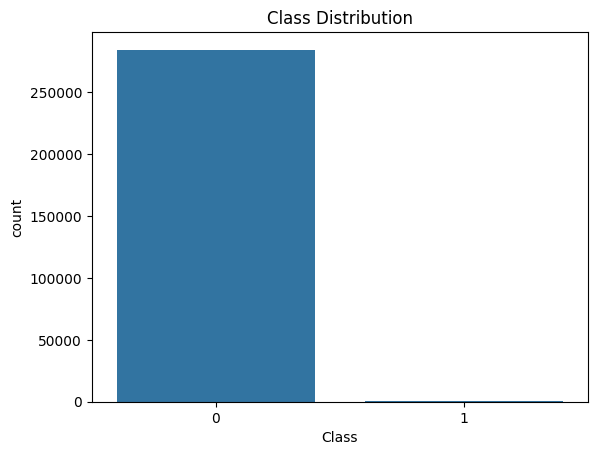

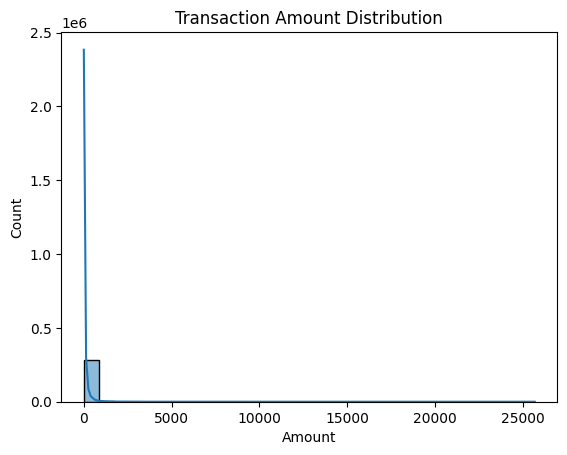

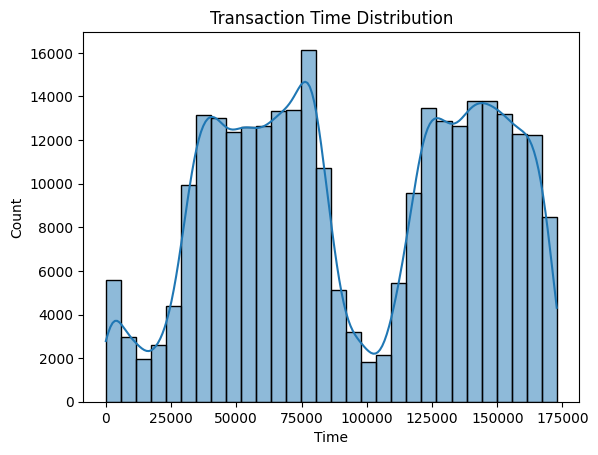

In [6]:
# Class distribution
sns.countplot(data=df, x='Class')
plt.title("Class Distribution")
plt.show()

# Distribution of 'Amount'
sns.histplot(df['Amount'], bins=30, kde=True)
plt.title("Transaction Amount Distribution")
plt.show()

# Distribution of 'Time'
sns.histplot(df['Time'], bins=30, kde=True)
plt.title("Transaction Time Distribution")
plt.show()

**Data Preprocessing**

In [ ]:
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

X = df.drop(columns=['Class', 'Time'])
y = df['Class']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Addressing class imbalance in the training set
df_train = pd.concat([X_train, y_train], axis=1)
df_majority = df_train[df_train['Class'] == 0]
df_minority = df_train[df_train['Class'] == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

df_train_balanced = pd.concat([df_majority, df_minority_upsampled])
X_train_balanced = df_train_balanced.drop(columns=['Class'])
y_train_balanced = df_train_balanced['Class']

**Define Evaluation Function**

In [8]:
def evaluate_model_with_auprc(y_true, y_pred, model_name):
    print(f"Model: {model_name}")
    cm = confusion_matrix(y_true, y_pred)
    print(f"Confusion Matrix:\n{cm}")

    print(classification_report(y_true, y_pred))
    roc_auc = roc_auc_score(y_true, y_pred)
    print(f"AUC-ROC: {roc_auc}")

    auprc = average_precision_score(y_true, y_pred)
    print(f"AUPRC (Area Under Precision-Recall Curve): {auprc}")

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    plt.figure()
    plt.step(recall, precision, where='post', label=f'AUPRC = {auprc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend(loc="best")
    plt.show()

**Feedback Loop Function**

In [12]:
def feedback_loop(new_data, new_labels, model, model_type="autoencoder"):
    """
    Implements a feedback loop to retrain the model on new fraud patterns.

    Parameters:
    - new_data: New transaction data (features)
    - new_labels: True labels for new data
    - model: Trained model
    - model_type: Type of model (e.g., 'autoencoder', 'isolation_forest', 'svm')

    Returns:
    - Updated model
    """
    print("Retraining model with new fraud patterns...")

    if model_type == "autoencoder":
        model.fit(
            new_data, new_data,
            epochs=10, batch_size=32, verbose=1
        )
    elif model_type in ["isolation_forest", "svm"]:
        combined_data = np.vstack([X_train_balanced, new_data])
        combined_labels = np.hstack([y_train_balanced, new_labels])
        model.fit(combined_data)
    else:
        raise ValueError("Unsupported model type for feedback loop!")

    print("Model retrained successfully.")
    return model

# Function Call for Feedback Loop
# feedback_loop(new_transaction_data, new_labels, autoencoder, model_type="autoencoder")

**Isolation Forest Model**

Model: Isolation Forest
Confusion Matrix:
[[56864     0]
 [   98     0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.00      0.00      0.00        98

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962

AUC-ROC: 0.5
AUPRC (Area Under Precision-Recall Curve): 0.0017204452090867595


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


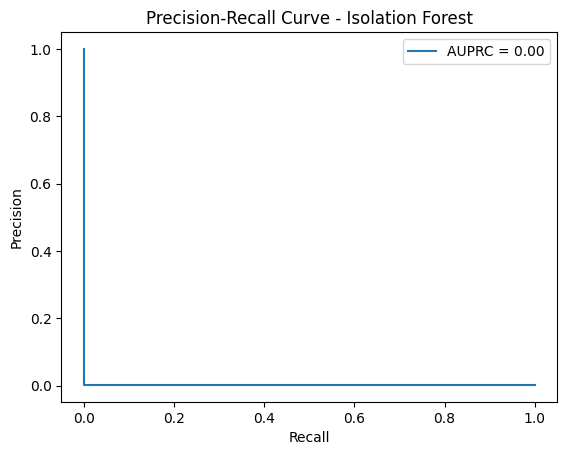

In [9]:
# Isolation Forest
isolation_forest = IsolationForest(random_state=42, contamination=0.0017)
isolation_forest.fit(X_train_balanced)
y_pred_isolation = isolation_forest.predict(X_test)

# Mapping predictions to binary classes
y_pred_isolation = np.where(y_pred_isolation == 1, 0, 1)

# Evaluating the model
evaluate_model_with_auprc(y_test, y_pred_isolation, "Isolation Forest")

**Autoencoder Model**

Epoch 1/20
14216/14216 [==============================] - 26s 2ms/step - loss: 13.5366 - val_loss: 0.9090
Epoch 2/20
14216/14216 [==============================] - 25s 2ms/step - loss: 13.4774 - val_loss: 0.9034
Epoch 3/20
14216/14216 [==============================] - 24s 2ms/step - loss: 13.4659 - val_loss: 0.8958
Epoch 4/20
14216/14216 [==============================] - 25s 2ms/step - loss: 13.4616 - val_loss: 0.8935
Epoch 5/20
14216/14216 [==============================] - 24s 2ms/step - loss: 13.4603 - val_loss: 0.8922
Epoch 6/20
14216/14216 [==============================] - 24s 2ms/step - loss: 13.4592 - val_loss: 0.8915
Epoch 7/20
14216/14216 [==============================] - 24s 2ms/step - loss: 13.4582 - val_loss: 0.8896
Epoch 8/20
14216/14216 [==============================] - 24s 2ms/step - loss: 13.4573 - val_loss: 0.8890
Epoch 9/20
14216/14216 [==============================] - 24s 2ms/step - loss: 13.4567 - val_loss: 0.8883
Epoch 10/20
14216/14216 [=====================

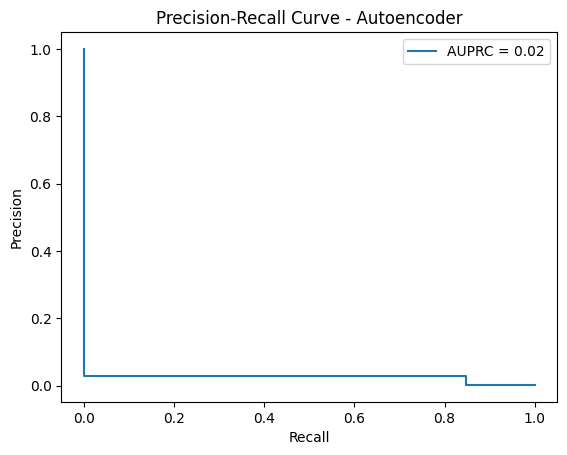

In [13]:
# Autoencoder Model
def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(14, activation='relu')(input_layer)
    encoded = Dense(7, activation='relu')(encoded)
    decoded = Dense(14, activation='relu')(encoded)
    output_layer = Dense(input_dim, activation='sigmoid')(decoded)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Training
input_dim = X_train_balanced.shape[1]
autoencoder = build_autoencoder(input_dim)
history = autoencoder.fit(
    X_train_balanced,
    X_train_balanced,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, X_test),
    verbose=1
)

# Reconstruction Errors
reconstruction_errors = np.mean(np.square(X_test - autoencoder.predict(X_test)), axis=1)

# Threshold for Fraud Detection
threshold = np.percentile(reconstruction_errors, 95)
y_pred_autoencoder = (reconstruction_errors > threshold).astype(int)

# Evaluating Autoencoder
evaluate_model_with_auprc(y_test, y_pred_autoencoder, "Autoencoder")

**Visualization of Results: Class Distribution After Balancing**

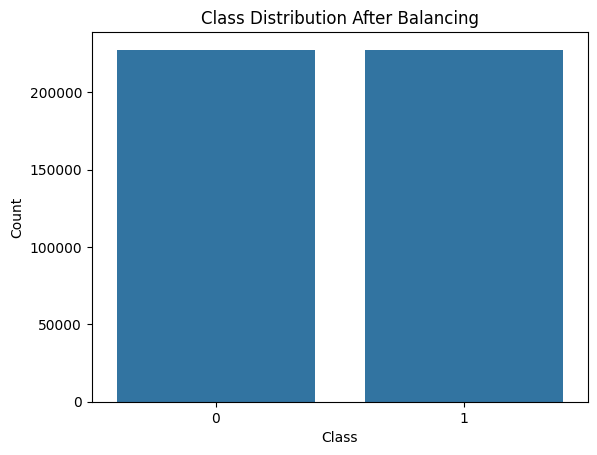

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualization of Class Distribution After Balancing
sns.countplot(x='Class', data=df_train_balanced)
plt.title("Class Distribution After Balancing")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

**SHAP: Model Interpretability**

  0%|          | 0/10 [00:00<?, ?it/s]

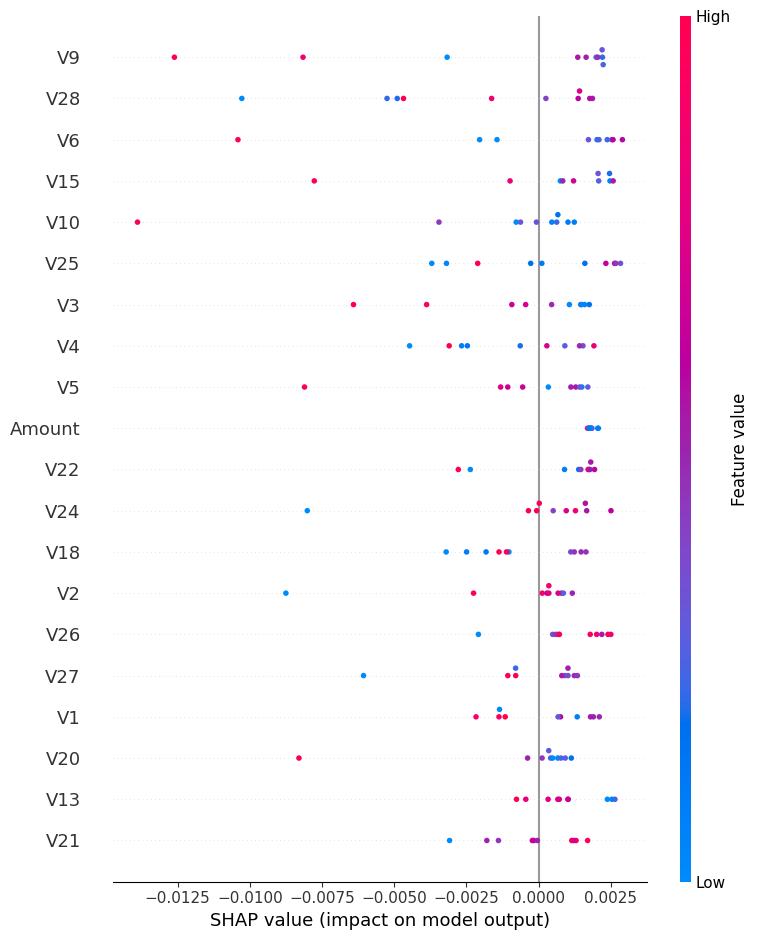

In [10]:
import shap

# SHAP Values for Isolation Forest
explainer = shap.KernelExplainer(isolation_forest.decision_function, X_test[:100])  # Use decision_function for anomaly scores
shap_values = explainer.shap_values(X_test[:10])  # Explain the first 10 samples for efficiency

# Summary Plot
shap.summary_plot(shap_values, X_test[:10])


4/4 [==============================] - 0s 2ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

6582/6582 [==============================] - 7s 1ms/step


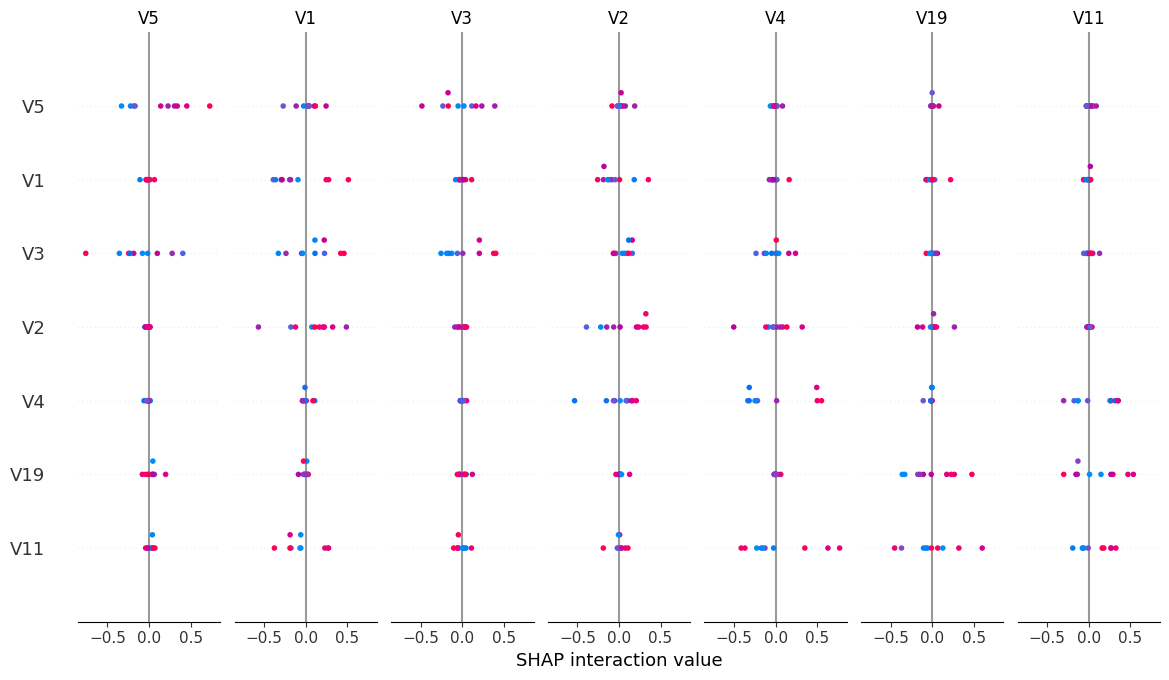

In [14]:
import shap

# SHAP Values for Autoencoder
explainer = shap.KernelExplainer(autoencoder.predict, X_test[:100])  # Use a subset for efficiency
shap_values = explainer.shap_values(X_test[:10])  # Explain for the first 10 samples

# Summary Plot
shap.summary_plot(shap_values, X_test[:10])